<a href="https://colab.research.google.com/github/cram05/practicas-machine-learning/blob/main/PCA_asl_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconocimiento de lenguaje de señas americano con PCA

En este notebook aplicaremos la tecnica de aprendizaje no supervisado, donde revisaremos un metodo para reduccion de dimensiones llamado PCA el cuál es muy útil para el análisis de datos multivariantes. Para la siguiente proyecto utilizaremos el dataset [ASL Alphabet](https://www.kaggle.com/grassknoted/asl-alphabet)

In [ ]:
# importamos las librerias necesarias
import io
import zipfile
import cv2
import math
import string
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter

## Recopilación de las imágenes

In [ ]:
# Descargamos el dataset
!wget https://github.com/carlosramos1/datasets/raw/main/asl-alphabet.zip

--2022-01-03 13:40:13--  https://github.com/carlosramos1/datasets/raw/main/asl-alphabet.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/carlosramos1/datasets/main/asl-alphabet.zip [following]
--2022-01-03 13:40:13--  https://raw.githubusercontent.com/carlosramos1/datasets/main/asl-alphabet.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25489344 (24M) [application/zip]
Saving to: ‘asl-alphabet.zip.1’

asl-alphabet.zip.1  100%[===================>]  24.31M  --.-KB/s    in 0.1s    

2022-01-03 13:40:13 (163 MB/s) - ‘asl-alphabet.zip.1’ saved [25489344/25489344]



In [ ]:
# Descomprimir y guardar las imágenes
images = []
labels = []

aux = tuple(l+"/" for l in string.ascii_uppercase) #('A/', 'B/', 'C/'...

with zipfile.ZipFile("asl-alphabet.zip") as aslZip:
  for filename in aslZip.namelist():
    if filename.startswith(aux) and filename.endswith(".jpg"):
      with aslZip.open(filename) as image:
        images.append(cv2.imdecode(np.frombuffer(image.read(), np.uint8), cv2.IMREAD_COLOR))
        labels.append(filename.split("/")[0])

print("Total imágenes:", len(images))
print("Total clases:", len(set(labels)))

Total imágenes: 780
Total clases: 26


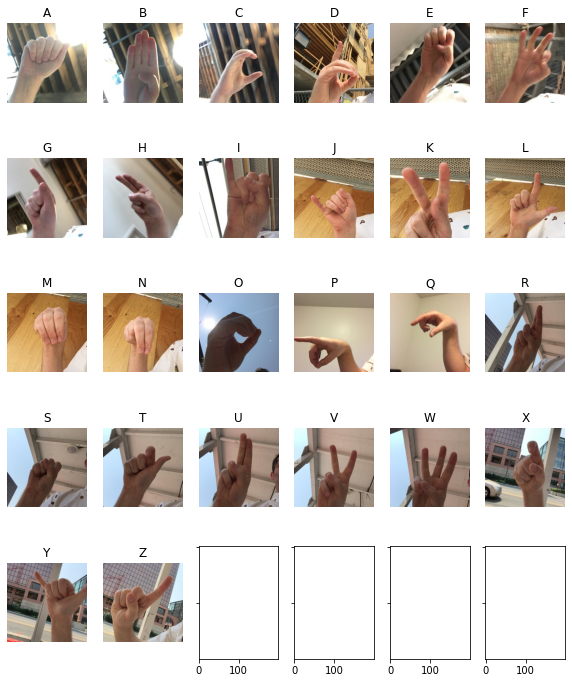

In [ ]:
# Mostramos algunas imágenes de las manos con señas
fig, axes = plt.subplots(5,6,sharex=True,sharey=True,figsize=(10,12))
idx = 0
letters = string.ascii_uppercase
for i in range(5):
  for j in range(6):
    if idx < 26:
      cell = axes[i][j]
      cell.axis('off')
      cell.imshow(cv2.cvtColor(images[labels.index(letters[idx])], cv2.COLOR_BGR2RGB))
      cell.set_title(letters[idx])
      idx += 1

plt.show()

## Preprocesamiento de la imagen

In [ ]:
# Instalamos la libreria MediaPipe de Google
!pip install mediapipe

     |████████████████████████████████| 32.7 MB 177 kB/s 


Con Media Pipe Hands encontraremos el área de la mano

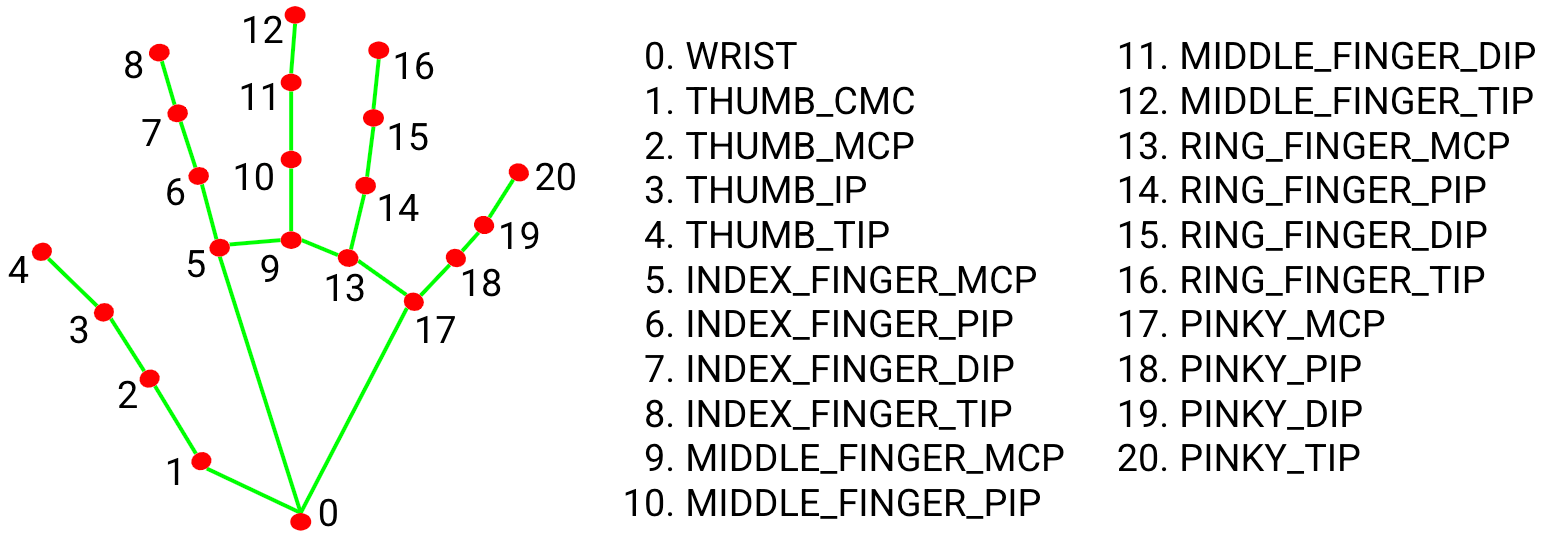

In [ ]:
import mediapipe as mp
hands = mp.solutions.hands.Hands(
    static_image_mode=True,
    max_num_hands=1,
    min_detection_confidence=0.7)

In [ ]:
# Definimos una función para segmentar la mano
def segment_hand(img):
  results = hands.process(cv2.flip(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), 1))

  if not results.multi_hand_landmarks:
      return False, ()

  image_hight, image_width, _ = img.shape
  all_pos_lm = [(lm.x * image_width, lm.y * image_hight) for hand_lm in results.multi_hand_landmarks for lm in hand_lm.landmark]

  left = max(all_pos_lm,key=itemgetter(0))
  right = min(all_pos_lm,key=itemgetter(0))
  top = min(all_pos_lm,key=itemgetter(1))
  bottom = max(all_pos_lm,key=itemgetter(1))

  x_0 = round(left[0] )
  y_0 = round(top[1] )
  w = abs(round(right[0] - x_0))
  h = abs(round(bottom[1] - y_0))

  return True, (abs(x_0 - image_width)-2, y_0-2, w+2, h+2)


### Normalizamos las imágenes:
1. Recortar el área de la mano
2. Convertir la imagen a scala de grises
3. Redimensionar a 120x120 px
4. Aplanamos la matriz (120,120) a una dimension

In [ ]:
# Recortar el área de la mano
# Convertir la imagen a scala de grises
# Redimensionar a 120x120 px
norm_width = 120
norm_height = 120

images_norm = []
labels_norm = []
for idx, img in enumerate(images):
  success, segment = segment_hand(img)
  if(success):
    x, y, w, h = segment
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    roi = img_gray[y:y + h, x:x + w]
    try:
      roi = cv2.resize(roi, (norm_width, norm_height), interpolation = cv2.INTER_CUBIC)
    except:
      continue
    roi = cv2.equalizeHist(roi)

    images_norm.append(roi.flatten())
    labels_norm.append(labels[idx])

X_norm = np.array(images_norm)
print("Muestras: ", X_norm.shape)

Muestras:  (725, 14400)


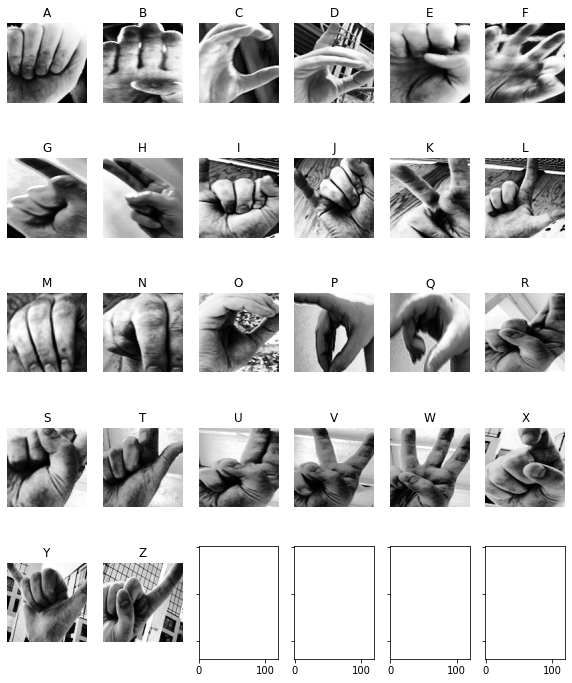

In [ ]:
# Mostramos algunas imágenes normalizadas
fig, axes = plt.subplots(5,6,sharex=True,sharey=True,figsize=(10,12))
idx = 0
letters = string.ascii_uppercase
for i in range(5):
  for j in range(6):
    if idx < 26:
      cell = axes[i][j]
      cell.axis('off')
      cell.imshow(X_norm[labels_norm.index(letters[idx])].reshape(norm_width, norm_height), cmap="gray")
      cell.set_title(letters[idx])
      idx += 1

plt.show()

## Dividir el dataset para entrenamiento y pruebas

In [ ]:
# Dividir datos de entrenamiento y pruebas
ns_test = 3 #cant. de imag. por clase
X_train, X_test, y_train, y_test = [], [], [], []
for letter in letters:
  indices = [idx for idx, l in enumerate(labels_norm) if l == letter ]

  idx_test = [indices.pop(0) for i in range(ns_test)]
  idx_train = indices

  for j in idx_train:
    X_train.append(X_norm[j])
    y_train.append(labels_norm[j])
  for k in idx_test:
    X_test.append(X_norm[k])
    y_test.append(labels_norm[k])

X_train = np.array(X_train); X_test = np.array(X_test)
y_train = np.array(y_train); y_test = np.array(y_test)

print("Datos entrenamiento", X_train.shape)
print("Datos pruebas", X_test.shape)

Datos entrenamiento (647, 14400)
Datos pruebas (78, 14400)


## Entrenamiento del modelo PCA

In [ ]:
from sklearn.decomposition import PCA

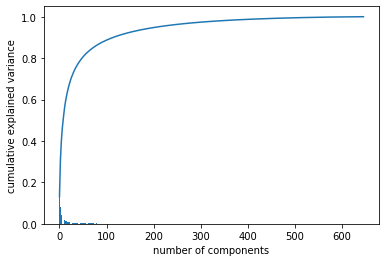

In [ ]:
# Varianza explicada acumuladoa de cada una de las componentes principales
pca = PCA()
pca.fit(X_train)

varianza = pca.explained_variance_ratio_
var_acum= np.cumsum(varianza)
plt.bar(range(len(varianza)), varianza)
plt.plot(range(len(varianza)), var_acum)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()


In [ ]:
model = PCA(n_components=100)

model.fit(X_train)

eigenvectors = model.components_
eigenvectors.shape

(100, 14400)

In [ ]:
# Visualizamos los componentes principales
eigenvectors

array([[-0.00246758, -0.00261488, -0.00248752, ..., -0.01355623,
        -0.01342185, -0.01314379],
       [ 0.00885934,  0.00883231,  0.0086435 , ..., -0.0007746 ,
        -0.00041086, -0.00011166],
       [-0.00682096, -0.00688574, -0.00712728, ...,  0.00245455,
         0.0024674 ,  0.00229479],
       ...,
       [ 0.01450615,  0.01260933,  0.01177251, ..., -0.00770078,
        -0.00446744, -0.00230215],
       [-0.02013766, -0.02239839, -0.02265201, ...,  0.00755586,
         0.0102257 ,  0.01172817],
       [ 0.00572474,  0.00728467,  0.00409724, ..., -0.00472017,
        -0.01166528, -0.01535829]])

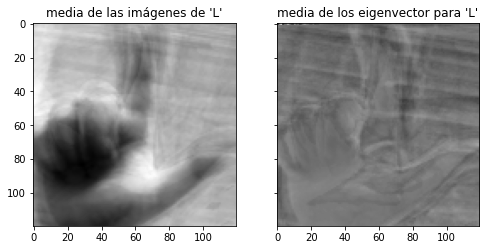

In [ ]:
# Visualizar la media y los componentes principales
fig, (ax1, ax2) = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,10))

tmpca = PCA().fit([X_train[i] for i in [idx for idx, l in enumerate(y_train) if l == "L" ]])
ax1.imshow(tmpca.mean_.reshape((120,120)), cmap="gray")
ax1.set_title("media de las imágenes de 'L'")

ax2.imshow(np.mean(tmpca.components_, axis=0).reshape((120,120)), cmap="gray")
ax2.set_title("media de los eigenvector para 'L'")

plt.show()

In [ ]:
# Transformacion de los datos a las nuevas componentes
X_p = model.transform(X_train)
print("X:  ", X_train.shape)
print("X_p:", X_p.shape)

X:   (647, 14400)
X_p: (647, 100)


In [ ]:
# Funcion para predecir
def predict(x0):  #x0 la imagen a predecir
  x_p0 = model.transform( [x0] )
  distances = np.linalg.norm((X_p - x_p0), axis=1)
  return np.argmin(distances)


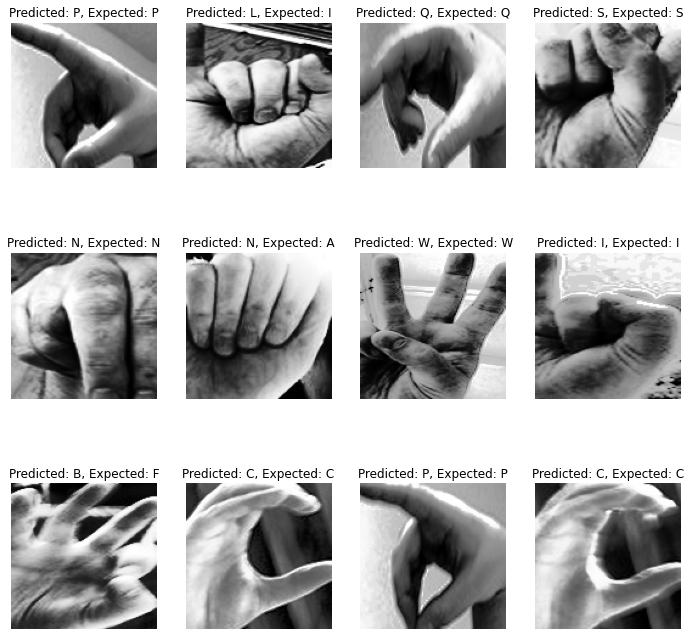

In [ ]:
# Predicir y Visualizar algunas imagenes
indices = np.arange(X_test.shape[0])
np.random.shuffle(indices)
index = 0

_, ax = plt.subplots(3, 4, figsize=(12, 12))

for i in range(3):
    for j in range(4):
        idx = indices[index]
        x0 = X_test[idx]
        prediction = predict(x0)

        cell = ax[i][j]

        cell.axis('off')
        cell.grid(False)
        cell.set_title('Predicted: ' + y_train[prediction] + ', Expected: ' + y_test[idx])
        cell.imshow(x0.reshape(120, 120), cmap='gray')

        index += 1

In [ ]:
# Predicciones con las imágenes (datos) de test
y_pred = []
for x_t in X_test:
  prediction = predict(x_t)
  y_pred.append(y_train[prediction])

y_pred = np.array(y_pred)
y_pred

array(['N', 'A', 'A', 'B', 'B', 'B', 'C', 'C', 'C', 'D', 'D', 'D', 'E',
       'E', 'E', 'B', 'F', 'F', 'G', 'G', 'G', 'H', 'H', 'H', 'L', 'L',
       'I', 'J', 'J', 'J', 'K', 'K', 'K', 'L', 'L', 'L', 'M', 'M', 'M',
       'N', 'N', 'N', 'O', 'O', 'O', 'P', 'P', 'P', 'Q', 'Q', 'Q', 'R',
       'R', 'R', 'S', 'S', 'S', 'T', 'T', 'T', 'U', 'U', 'U', 'V', 'V',
       'V', 'W', 'W', 'W', 'X', 'X', 'X', 'Y', 'Y', 'Y', 'Z', 'Z', 'Z'],
      dtype='<U1')

In [ ]:
y_test

array(['A', 'A', 'A', 'B', 'B', 'B', 'C', 'C', 'C', 'D', 'D', 'D', 'E',
       'E', 'E', 'F', 'F', 'F', 'G', 'G', 'G', 'H', 'H', 'H', 'I', 'I',
       'I', 'J', 'J', 'J', 'K', 'K', 'K', 'L', 'L', 'L', 'M', 'M', 'M',
       'N', 'N', 'N', 'O', 'O', 'O', 'P', 'P', 'P', 'Q', 'Q', 'Q', 'R',
       'R', 'R', 'S', 'S', 'S', 'T', 'T', 'T', 'U', 'U', 'U', 'V', 'V',
       'V', 'W', 'W', 'W', 'X', 'X', 'X', 'Y', 'Y', 'Y', 'Z', 'Z', 'Z'],
      dtype='<U1')

## Validación del modelo

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import pandas as pd
import seaborn as sns

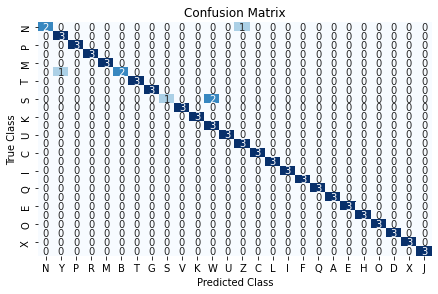

In [ ]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# crear marco de datos de pandas Crear un conjunto de datos
dataframe = pd.DataFrame(cm, index=set(labels), columns=set(labels))

# crear mapa de calor dibujar mapa de calor
sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [ ]:
# exactitud
ex = accuracy_score(y_test, y_pred)
print('La exactitud es: {}'.format(ex))

La exactitud es: 0.9487179487179487
